In [1]:
# Import the necessary modules
from top_n_tool import run_tool

c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import langchain
from langchain.cache import SQLiteCache
langchain.llm_cache = SQLiteCache(database_path=".st_langchain.db")

In [3]:
from IPython.display import Markdown, display, HTML

In [4]:
# Define the user query
user_query = """
I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.
"""

In [5]:
result_gpt3 = run_tool(user_query, top_n=10, model_name="gpt-3.5-turbo")

100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


* GPT-3.5-turbo

In [6]:
Markdown(f"{result_gpt3}")

## New Query:

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

## Model Response:
To address the new query, we can draw comparisons from several past cases:

1. In [[1](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/)], an individual sought advice on protecting their computer program/app idea when discussing it with potential collaborators. The suggestions included obtaining a patent and entering into non-disclosure agreements (NDAs) with collaborators. These measures can be relevant in the current scenario to protect the video game concept and 3D models.

2. In [[3](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)], an individual considered working as an independent contractor for a startup. They were concerned about potential issues and sought advice on how to avoid complications. This case can provide insights into potential risks and considerations when hiring independent contractors for the video game project.

3. In [[6](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/)], a content creator wanted to outsource video editing work to a friend in a different country. They sought clarification on whether the friend should be classified as an independent contractor or an employee. This case can provide guidance on the classification of contractors and the legal implications associated with hiring contractors from different countries.

4. In [[8](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/)], a startup founder had concerns about paying a contractor who had not completed any projects. They sought clarification on whether they had the right to withhold payment. This case can provide insights into the legal considerations when it comes to paying contractors for their work.

By referencing these past cases, the researcher can gain insights into the potential risks and legal measures to consider when hiring independent contractors for the video game project. They can explore options such as obtaining patents, entering into NDAs, clarifying contractor classifications, and ensuring proper payment terms to protect their intellectual property and ensure fair compensation for the contractors. Additionally, they can seek advice from an intellectual property attorney to navigate the legal complexities involved in protecting their intellectual property across different states and countries.
##### [8] ["Legal implications of not paying a contractor during probation period in a startup"](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/) - HI, 2018-01-23, Number: 906
##### [6] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24, Number: 4123
##### [3] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22, Number: 8236
##### [1] ["Protecting your idea while collaborating with strangers in the California Bay Area tech scene"](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/) - IA, 2015-03-05, Number: 1253


In [7]:
result_gpt_4 = run_tool(user_query, top_n=10, model_name="gpt-4")

100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


* GPT-4

In [8]:
Markdown(f"{result_gpt_4}")

## New Query:

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

## Model Response:
The new query involves a video game designer who is planning to hire independent contractors for programming and 3D modelling tasks. The designer is seeking advice on how to protect their intellectual property and ensure that the contractors are paid for their work. This situation can be compared to several past cases.

In [[1](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/)], the individual was concerned about protecting their computer program/app idea when discussing it with potential collaborators. The advice given was to consider obtaining a patent and entering into a non-disclosure agreement (NDA) with potential collaborators. This advice could be applicable to the new query as well, as the designer could consider obtaining a patent for their video game and having the contractors sign an NDA to protect the game concept and 3D models.

In [[3](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)], the individual was considering a job offer from a startup that required assistance with software development. The startup wanted the copyright to the individual's code and wanted to ensure that the individual was not liable for any mistakes after the contract ended. This situation is similar to the new query, as the designer could consider including similar terms in the contracts with the contractors to protect their intellectual property and limit their liability.

In [[6](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/)], the individual was a content creator who was seeking assistance in video editing from a friend who resided in a different country. The content creator was unsure whether the friend should be classified as an independent contractor or an employee. This situation could be relevant to the new query, as the designer may need to hire contractors from different states or countries.

In [[7](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/)], the individual and their friends formed an LLC to protect their intellectual property and make their business more official. This could be a potential strategy for the designer to consider, as forming an LLC could provide additional protection for their intellectual property.

In [[8](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/)], the founder of a startup was unsure about paying a contractor due to their lack of work. This situation could be relevant to the new query, as the designer may need to consider how to handle payment issues with the contractors.

In [[9](https://www.reddit.com/r/legaladvice/comments/e635kk/how_to_structure_equity_agreement/)], the founder of a company and a designer reached a verbal agreement regarding the division of equity and revenue share. This could be a potential strategy for the designer to consider, as they could potentially offer equity or revenue share to the contractors as a form of compensation.

In [[10](https://www.reddit.com/r/legaladvice/comments/7x69a3/im_writing_my_own_contract_for_freelance_work_and/)], a graphic designer was seeking assistance in reviewing and revising their terms and conditions, specifically focusing on the payment schedule section. This could be relevant to the new query, as the designer may need to consider how to structure the payment schedule in the contracts with the contractors.
##### [3] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22, Number: 8236
##### [10] ["Clarifying payment schedule in graphic designer's terms and conditions in Texas"](https://www.reddit.com/r/legaladvice/comments/7x69a3/im_writing_my_own_contract_for_freelance_work_and/) - IA, 2018-02-13, Number: 59
##### [6] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24, Number: 4123
##### [1] ["Protecting your idea while collaborating with strangers in the California Bay Area tech scene"](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/) - IA, 2015-03-05, Number: 1253
##### [8] ["Legal implications of not paying a contractor during probation period in a startup"](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/) - HI, 2018-01-23, Number: 906
##### [7] [Navigating Legal Contracts: Protecting Your Business and Seeking Legal Support](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/) - LA, 2015-03-01, Number: 2499
##### [9] ["Structuring a temporary agreement for equity split and revenue share in a startup partnership"](https://www.reddit.com/r/legaladvice/comments/e635kk/how_to_structure_equity_agreement/) - VA, 2019-12-04, Number: 2513


In [5]:
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from auto_coder import ResearchPastQuestions

In [7]:
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

In [8]:
research_past_questions = ResearchPastQuestions()

In [9]:
agent_test = initialize_agent(
    [research_past_questions],
    llm,
    verbose=True,
)

In [10]:
test_1 = agent_test.run(f"Find past cases for: {user_query}")



> Entering new AgentExecutor chain...
I should use the research_past_questions tool to find similar cases where someone needed to hire contractors for a video game project and protect their intellectual property.
Action: research_past_questions
Action Input: "hiring contractors for video game project intellectual property protection"

100%|██████████| 1/1 [00:00<00:00, 500.10it/s]



Observation: ## New Query:
hiring contractors for video game project intellectual property protection
## Model Response:
To address the new query regarding hiring contractors for video game project intellectual property protection, we can draw insights from several past cases.

In [[1](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/)], an individual sought advice on protecting their intellectual property while hiring independent contractors for a video game project. They were concerned about contractors taking the game concept or 3D models and running away with them. The individual was advised to use contracts to address these concerns. This case provides a starting point for understanding the importance of contracts in protecting intellectual property when working with contractors.

Similarly, in [[3](https://www.reddit.com/r/legaladvice/comments/4z18de/non_disclosure_agreement_questions/)], a company wanted to protect its information when hiring

In [11]:
Markdown(f"{test_1}")

## New Query:
hiring contractors for video game project intellectual property protection
## Model Response:
To address the new query regarding hiring contractors for video game project intellectual property protection, we can draw insights from several past cases.

In [[1](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/)], an individual sought advice on protecting their intellectual property while hiring independent contractors for a video game project. They were concerned about contractors taking the game concept or 3D models and running away with them. The individual was advised to use contracts to address these concerns. This case provides a starting point for understanding the importance of contracts in protecting intellectual property when working with contractors.

Similarly, in [[3](https://www.reddit.com/r/legaladvice/comments/4z18de/non_disclosure_agreement_questions/)], a company wanted to protect its information when hiring another company to develop back-end systems. They planned to send a Non-Disclosure Agreement (NDA) to the contractor to prevent unauthorized use of the information. This case highlights the use of NDAs as a tool to safeguard confidential information and prevent its unauthorized use.

Furthermore, in [[4](https://www.reddit.com/r/legaladvice/comments/2tkwy4/uk_job_contract_asking_me_to_waive_moral_rights/)], an individual received a job contract for a software development position and had concerns about intellectual property rights. The contract asked the individual to waive their moral rights and stated that all IP created during the course of employment would belong to the company. This case raises questions about the ownership of IP created during employment and the implications of waiving moral rights. It emphasizes the importance of understanding the terms of contracts and their impact on intellectual property rights.

Additionally, in [[8](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)], an individual considered a job offer as an independent contractor for a startup. The startup wanted the copyright to the individual's code and sought to ensure that the individual would not be liable for any mistakes after the contract ended. This case highlights the need to carefully review and negotiate the terms of contracts when working as an independent contractor, particularly regarding intellectual property rights and liability.

By referencing these past cases, the researcher can gain insights into the importance of contracts, including NDAs, in protecting intellectual property when hiring contractors for a video game project. They can also consider the implications of waiving moral rights and the ownership of IP created during employment. Additionally, the researcher can explore the need to review and negotiate the terms of contracts to address intellectual property rights and liability concerns when working as an independent contractor.
##### [8] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22, Number: 8236
##### [3] ["Protecting Intellectual Property: Is an NDA Sufficient to Safeguard Technical Analysis and Prevent Competitor Exploitation?"](https://www.reddit.com/r/legaladvice/comments/4z18de/non_disclosure_agreement_questions/) - MO, 2016-08-22, Number: 1891
##### [4] [Navigating Intellectual Property Rights and Employment Contracts: Understanding Moral Rights and the Scope of "Course of Employment"](https://www.reddit.com/r/legaladvice/comments/2tkwy4/uk_job_contract_asking_me_to_waive_moral_rights/) - SC, 2015-01-25, Number: 2449
##### [1] ["Protecting Intellectual Property and Ensuring Payment: Legal Considerations for Hiring Independent Contractors in the Video Game Industry"](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/) - OR, 2020-05-12, Number: 8627


In [16]:
test_2 = agent_test.run(f"Using the research_past_questions tool, input this exact text:\n\n{user_query}")



> Entering new AgentExecutor chain...
I should use the research_past_questions tool to find similar cases where someone needed advice on contracts and intellectual property protection for hiring independent contractors for a video game project.
Action: research_past_questions
Action Input: "advice on contracts and intellectual property protection for hiring independent contractors for a video game project"

100%|██████████| 1/1 [00:00<00:00, 499.92it/s]



Observation: ## New Query:
advice on contracts and intellectual property protection for hiring independent contractors for a video game project
## Model Response:
To address the new query regarding advice on contracts and intellectual property protection for hiring independent contractors for a video game project, we can draw insights from several past cases.

In [[1](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/)], an individual sought advice on how to protect their intellectual property and ensure that independent contractors/freelancers are paid for their work in the context of designing a video game. They were concerned about contractors taking the game concept or 3D models and running away with them. This case provides a starting point for understanding the importance of protecting intellectual property and ensuring proper compensation for contractors.

Similarly, in [[2](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_

In [17]:
Markdown(f"{test_2}")

## New Query:
advice on contracts and intellectual property protection for hiring independent contractors for a video game project
## Model Response:
To address the new query regarding advice on contracts and intellectual property protection for hiring independent contractors for a video game project, we can draw insights from several past cases.

In [[1](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/)], an individual sought advice on how to protect their intellectual property and ensure that independent contractors/freelancers are paid for their work in the context of designing a video game. They were concerned about contractors taking the game concept or 3D models and running away with them. This case provides a starting point for understanding the importance of protecting intellectual property and ensuring proper compensation for contractors.

Similarly, in [[2](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/)], an 18-year-old college student and their friends formed an LLC to protect their intellectual property in a tech-based project. They were about to sign a large contract with a business entity and sought advice on how to protect themselves and navigate interactions with the company's legal team. This case highlights the significance of forming a legal entity and seeking legal support to protect intellectual property when entering into contracts.

In [[3](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/)], an individual sought advice on how to protect their computer program/app idea when discussing it with potential collaborators. They were concerned about someone stealing their idea and developing it themselves. This case emphasizes the importance of considering options such as obtaining a patent and entering into non-disclosure agreements to safeguard intellectual property.

Furthermore, in [[4](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)], an individual was considering a job offer from a startup as an independent contractor. The startup wanted the copyright to the individual's code and sought to limit liability after the contract ends. This case raises awareness about potential issues to watch out for when working as an independent contractor and the importance of understanding the terms of the contract, including intellectual property rights and liability.

Additionally, in [[5](https://www.reddit.com/r/legaladvice/comments/gpm6sc/3rd_party_unauthorized_use_do_you_need_that_in_a/)], an individual negotiating a contract for illustration work was unsure if the contract needed to address the lack of responsibility for third-party unauthorized use. This case highlights the importance of addressing potential issues related to intellectual property in contracts, including unauthorized third-party use.

Lastly, in [[6](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/)], an individual sought clarification on whether a friend who would handle video editing work on a project-by-project basis should be classified as an independent contractor or an employee. This case provides insights into the classification of workers and the implications it may have on contracts and intellectual property rights.

By referencing these past cases, the researcher can gain insights into the importance of protecting intellectual property, forming legal entities, understanding contract terms, considering options such as patents and non-disclosure agreements, and addressing potential issues related to unauthorized use and worker classification. These insights can inform the researcher's analysis and advice on contracts and intellectual property protection for hiring independent contractors for a video game project.
##### [2] [Navigating Legal Contracts: Protecting Your Business and Seeking Legal Support](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/) - LA, 2015-03-01, Number: 2499
##### [3] ["Protecting your idea while collaborating with strangers in the California Bay Area tech scene"](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/) - IA, 2015-03-05, Number: 1253
##### [6] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24, Number: 4123
##### [1] ["Protecting Intellectual Property and Ensuring Payment: Legal Considerations for Hiring Independent Contractors in the Video Game Industry"](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/) - OR, 2020-05-12, Number: 8627
##### [5] ["Understanding Liability in Contracts: Addressing Third-Party Unauthorized Use in Illustration Work"](https://www.reddit.com/r/legaladvice/comments/gpm6sc/3rd_party_unauthorized_use_do_you_need_that_in_a/) - SD, 2020-05-24, Number: 1220
##### [4] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22, Number: 8236


In [18]:
llm_gpt4 = ChatOpenAI(temperature=0, model="gpt-4")

agent_test_gpt4 = initialize_agent(
    [research_past_questions],
    llm=llm_gpt4,
    verbose=True,
)

In [19]:
test_1_gpt4 = agent_test_gpt4.run(f"Find past cases for the following new question. Use the exact question for the search: {user_query}")



> Entering new AgentExecutor chain...
The user is asking for advice on contracts for hiring independent contractors or freelancers for a video game project, with a focus on ensuring payment for work and protection of intellectual property. They also mention concerns about potential theft of their game concept or 3D models. I should look for past questions that deal with similar issues.
Action: research_past_questions
Action Input: I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their

100%|██████████| 1/1 [00:00<00:00, 500.04it/s]



Observation: ## New Query:
I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.
## Model Response:
To address the new query, we can draw comparisons from several past cases:

1. In [[3](https://www.re

* GPT-4 follows directions

In [20]:
Markdown(f"{test_1_gpt4}")

## New Query:
I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.
## Model Response:
To address the new query, we can draw comparisons from several past cases:

1. In [[3](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)], an individual was considering working as an independent contractor for a startup. They were concerned about potential issues and steps to take to avoid future complications. This case can provide insights into the precautions that can be taken when hiring independent contractors, such as having a clear contract that outlines the scope of work, payment terms, and intellectual property rights.

2. In [[6](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/)], a content creator wanted to outsource video editing work to a friend in a different country. They sought clarification on whether the friend should be classified as an independent contractor or an employee. This case can provide guidance on the classification of contractors and the legal implications associated with hiring contractors from different countries.

3. In [[9](https://www.reddit.com/r/legaladvice/comments/e635kk/how_to_structure_equity_agreement/)], a founder and a designer reached a verbal agreement regarding equity and revenue share. They wanted to have a temporary agreement in place until they could afford a more comprehensive legal agreement. This case can offer insights into structuring temporary agreements and using templates as a starting point.

By referencing these past cases, the researcher can gain insights into the precautions that can be taken when hiring independent contractors, the classification of contractors from different countries, and the structuring of temporary agreements. These insights can help address the new query and provide guidance on how to ensure that contractors get paid for their work and how to protect intellectual property.
##### [6] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24, Number: 4123
##### [9] ["Structuring a temporary agreement for equity split and revenue share in a startup partnership"](https://www.reddit.com/r/legaladvice/comments/e635kk/how_to_structure_equity_agreement/) - VA, 2019-12-04, Number: 2513
##### [3] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22, Number: 8236


* Run the LangChain custom tool by itself. Should be equivalent to calling the `run_tool` vanilla python function

In [8]:
tool_test = research_past_questions.run(user_query)
Markdown(f"{tool_test}")

100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


## New Query:

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

## Model Response:
To address the new query, we can draw comparisons from several past cases:

1. In [[1](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/)], an individual sought advice on protecting their computer program/app idea when discussing it with potential collaborators. The suggestions included obtaining a patent and entering into non-disclosure agreements (NDAs) with collaborators. These measures can be relevant in the current scenario to protect the video game concept and 3D models.

2. In [[3](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)], an individual considered working as an independent contractor for a startup. They were concerned about potential issues and sought advice on how to avoid complications. This case can provide insights into potential risks and considerations when hiring independent contractors for the video game project.

3. In [[6](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/)], a content creator wanted to outsource video editing work to a friend in a different country. They sought clarification on whether the friend should be classified as an independent contractor or an employee. This case can provide guidance on the classification of contractors and the legal implications associated with hiring contractors from different countries.

4. In [[8](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/)], a startup founder had concerns about paying a contractor who had not completed any projects. They sought clarification on whether they had the right to withhold payment. This case can provide insights into the legal considerations when it comes to paying contractors for their work.

By referencing these past cases, the researcher can gain insights into the potential risks and legal measures to consider when hiring independent contractors for the video game project. They can explore options such as obtaining patents, entering into NDAs, clarifying contractor classifications, and ensuring proper payment terms to protect their intellectual property and ensure fair compensation for the contractors. Additionally, they can seek advice from an intellectual property attorney to navigate the legal complexities involved in protecting their intellectual property across different states and countries.
##### [6] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24, Number: 4123
##### [8] ["Legal implications of not paying a contractor during probation period in a startup"](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/) - HI, 2018-01-23, Number: 906
##### [1] ["Protecting your idea while collaborating with strangers in the California Bay Area tech scene"](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/) - IA, 2015-03-05, Number: 1253
##### [3] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22, Number: 8236


## LLama Index "Data Agents"

In [12]:
from llama_index.agent import ReActAgent
from llama_index.llms import OpenAI

In [13]:
from llama_index.tools.function_tool import FunctionTool

* This next function is **important**!
* The LLM will use param names, docstrings, and type hints to infer the input structure

In [14]:
def get_top_n_report(query: str, top_n: int) -> str:
    """
    Takes a user query and returns a string of top n similar texts.
    """
    return run_tool(query, top_n)
    

In [15]:
function_tool = FunctionTool.from_defaults(fn=get_top_n_report)

In [16]:
from typing import Tuple, List
from llama_index.llms.base import ChatResponse
from llama_index.agent.react.types import BaseReasoningStep

class ReActAgentWrapper(ReActAgent):
    def _process_actions(
        self, output: ChatResponse
    ) -> Tuple[List[BaseReasoningStep], bool]:
        reasoning_steps, is_done = super()._process_actions(output)
        print("Reasoning Steps:", reasoning_steps)
        return reasoning_steps, is_done

    async def _aprocess_actions(
        self, output: ChatResponse
    ) -> Tuple[List[BaseReasoningStep], bool]:
        reasoning_steps, is_done = await super()._aprocess_actions(output)
        print("Reasoning Steps:", reasoning_steps)
        return reasoning_steps, is_done

In [45]:
class ReActAgentWrapperReasoning(ReActAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reasoning_steps_history = []
        self.latest_reasoning_step = None

    def _process_actions(
        self, output: ChatResponse
    ) -> Tuple[List[BaseReasoningStep], bool]:
        reasoning_steps, is_done = super()._process_actions(output)
        self.reasoning_steps_history.append(reasoning_steps)
        self.latest_reasoning_step = reasoning_steps[-1] if reasoning_steps else None
        return reasoning_steps, is_done

    async def _aprocess_actions(
        self, output: ChatResponse
    ) -> Tuple[List[BaseReasoningStep], bool]:
        reasoning_steps, is_done = await super()._aprocess_actions(output)
        self.reasoning_steps_history.append(reasoning_steps)
        self.latest_reasoning_step = reasoning_steps[-1] if reasoning_steps else None
        return reasoning_steps, is_done


In [46]:
llm = OpenAI(model="gpt-3.5-turbo")
# initialize ReAct agent
agent = ReActAgentWrapperReasoning.from_tools([function_tool], llm=llm, verbose=True)

In [47]:
data_agent_test_1 = agent.chat(f"Get the top 15 cases similar to this query: {user_query}")

Thought: I need to use a tool to help me find similar cases to the user's query.
Action: get_top_n_report
Action Input: {'query': "I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a 'proof of concept' in order to better secure initial income via crowdfunding. At this point: I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.", 'top_n': 15}


100%|██████████| 1/1 [00:00<00:00, 500.16it/s]


Observation: ## Model Response:
To address the new query, we can draw comparisons from several past cases:

1. In [[2](https://www.reddit.com/r/legaladvice/comments/ea7t71/what_are_my_best_steps_to_form_a_business/)], an individual sought guidance on forming an LLC and the implications of different types of business entities. This case can provide insights into the legal structure that the game designer may consider when hiring independent contractors.

2. In [[5](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)], an individual in Wisconsin sought advice on potential issues to watch out for when working as an independent contractor. This case can provide insights into the considerations and precautions the game designer should take when hiring independent contractors.

3. In [[6](https://www.reddit.com/r/legaladvice/comments/gn4sdf/does_this_count_as_a_business_what_do_i_need_to/)], an individual sought advice on how to protect th

In [52]:
def pretty_format_dict(d):
    return '\n'.join(f'{k}: {v}' for k, v in d.items())

In [58]:
agent.reasoning_steps_history[0][0].thought

"I need to use a tool to help me find similar cases to the user's query."

In [57]:
agent.reasoning_steps_history[0][0].action

'get_top_n_report'

In [54]:
d = agent.reasoning_steps_history[0][0].action_input

print(pretty_format_dict(d))

query: I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a 'proof of concept' in order to better secure initial income via crowdfunding. At this point: I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.
top_n: 15


In [55]:
agent.latest_reasoning_step

ResponseReasoningStep(thought='I can answer without using any more tools.', response='Based on the similar cases, here are some recommendations for the game designer:')

In [40]:
agent.reasoning_steps_history[0][0].action_input

{'query': "I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a 'proof of concept' in order to better secure initial income via crowdfunding. At this point: I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.",
 'top_n': 15}

In [32]:
Markdown(f"{agent.reasoning_steps_history[0][1].observation}")

## Model Response:
To address the new query, we can draw comparisons from several past cases:

1. In [[2](https://www.reddit.com/r/legaladvice/comments/ea7t71/what_are_my_best_steps_to_form_a_business/)], an individual sought guidance on forming an LLC and the implications of different types of business entities. This case can provide insights into the legal structure that the game designer may consider when hiring independent contractors.

2. In [[5](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)], an individual in Wisconsin sought advice on potential issues to watch out for when working as an independent contractor. This case can provide insights into the considerations and precautions the game designer should take when hiring independent contractors.

3. In [[6](https://www.reddit.com/r/legaladvice/comments/gn4sdf/does_this_count_as_a_business_what_do_i_need_to/)], an individual sought advice on how to protect themselves legally when integrating a donations system into their gaming community. This case can provide insights into the legal measures the game designer can take to protect their intellectual property and ensure that contractors are paid for their work.

4. In [[8](https://www.reddit.com/r/legaladvice/comments/51psea/kickstarter_for_a_tabletop_rpg_book_do_i_need_an/)], an individual planning to launch a Kickstarter campaign sought advice on whether forming an LLC was necessary to protect their intellectual property. This case can provide insights into the considerations the game designer should make regarding the protection of their intellectual property.

By referencing these past cases, the game designer can gain insights into the legal steps they can take to protect their intellectual property and ensure that contractors are paid for their work. They can also learn about the potential issues to watch out for when working with independent contractors and the implications of different business entities. Additionally, they can explore the legal requirements for integrating a donations system and consider whether forming an LLC is necessary for their specific situation.
##### [6] ["Legal considerations for setting up a gaming community donations system and hiring developers"](https://www.reddit.com/r/legaladvice/comments/gn4sdf/does_this_count_as_a_business_what_do_i_need_to/) - HI, 2020-05-20, Number: 5183
##### [2] ["Forming an LTD for a graphic artist and game designer: business structure, name reservation, and financial implications"](https://www.reddit.com/r/legaladvice/comments/ea7t71/what_are_my_best_steps_to_form_a_business/) - MP, 2019-12-13, Number: 1270
##### [5] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22, Number: 8236
##### [8] ["Legal considerations for launching a Kickstarter campaign and selling a self-published book online"](https://www.reddit.com/r/legaladvice/comments/51psea/kickstarter_for_a_tabletop_rpg_book_do_i_need_an/) - FM, 2016-09-08, Number: 8170


In [16]:
data_agent_test_2 = agent.chat(f"Please run that again but this time get 20 cases")

Thought: I need to use a tool to help me answer the question.
Action: get_top_n_report
Action Input: {'query': "I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a 'proof of concept' in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.", 'top_n': 20}


100%|██████████| 1/1 [00:00<00:00, 507.72it/s]


Observation: ## New Query:
I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a 'proof of concept' in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.
## Model Response:
In order to address the new query, we can draw comparisons to several past cases that involve hiring i

* Test without function calling api

In [17]:
llm_no_fun = OpenAI(model="gpt-3.5-turbo")
# initialize ReAct agent
agent_no_fun = ReActAgent.from_tools([function_tool], llm=llm_no_fun, verbose=True)

In [18]:
data_agent_nf_test_1 = agent_no_fun.chat(f"Get the top 15 cases similar to this query: {user_query}")

Thought: I need to use a tool to help me find similar cases to the user's query.
Action: get_top_n_report
Action Input: {'query': "I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a 'proof of concept' in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.", 'top_n': 15}


100%|██████████| 1/1 [00:00<00:00, 552.25it/s]


Observation: ## New Query:
I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a 'proof of concept' in order to better secure initial income via crowdfunding. At this point:  I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.
## Model Response:
To address the new query, we can draw comparisons from several past cases:

1. In [[2](https://www.red

In [19]:
data_agent_nf_test_2 = agent_no_fun.chat(f"Please run that again but this time get 5 cases")

Thought: I need to use a tool to help me find similar cases.
Action: get_top_n_report
Action Input: {'query': "I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a 'proof of concept' in order to better secure initial income via crowdfunding. At this point: I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.", 'top_n': 5}


100%|██████████| 1/1 [00:00<00:00, 500.33it/s]


Observation: ## New Query:
I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a 'proof of concept' in order to better secure initial income via crowdfunding. At this point: I have virtually no initial startup funds. So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.
## Model Response:
To address the new query, we can draw comparisons from several of the previous search results:

1. In [

In [1]:
import pandas as pd

df = pd.read_parquet("reddit_legal_cluster_test_results.parquet")
df['timestamp'] = pd.to_datetime(df['created_utc'], unit='s')
df['datestamp'] = df['timestamp'].dt.date
df.rename(columns={"State": "state",
                   "kmeans_label": "cluster"}, inplace=True)

In [8]:
# NOTE: This is ONLY necessary in jupyter notebook.
# Details: Jupyter runs an event-loop behind the scenes.
#          This results in nested event-loops when we start an event-loop to make async queries.
#          This is normally not allowed, we use nest_asyncio to allow it for convenience.

import nest_asyncio
nest_asyncio.apply()

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [9]:
from llama_index import (
    VectorStoreIndex,
    ServiceContext,
    StorageContext,
    SQLDatabase,
)

from llama_index.node_parser.simple import SimpleNodeParser
import chromadb
from llama_index.vector_stores import ChromaVectorStore
from langchain.text_splitter import TokenTextSplitter
from llama_index.llms import OpenAI


from llama_index.indices.struct_store.sql_query import NLSQLTableQueryEngine
from llama_index.indices.struct_store.sql import SQLStructStoreIndex
from llama_index.schema import TextNode

from llama_index.query_engine import SQLAutoVectorQueryEngine, RetrieverQueryEngine
from llama_index.tools.query_engine import QueryEngineTool
from llama_index.indices.vector_store import VectorIndexAutoRetriever

from llama_index.indices.vector_store.retrievers import VectorIndexAutoRetriever
from llama_index.vector_stores.types import MetadataInfo, VectorStoreInfo
from llama_index.query_engine.retriever_query_engine import RetrieverQueryEngine

In [10]:
# define node parser and LLM
chunk_size = 1024
llm = OpenAI(temperature=0, model="gpt-3.5-turbo", streaming=False)
service_context = ServiceContext.from_defaults(chunk_size=chunk_size, llm=llm)

text_splitter = TokenTextSplitter(chunk_size=chunk_size)
node_parser = SimpleNodeParser(text_splitter=text_splitter)

In [11]:
#create chroma client and collection
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("reddit_legal")

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
vector_index = VectorStoreIndex([], storage_context=storage_context)

INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.
Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


In [12]:
from sqlalchemy import create_engine, MetaData, Table, Column, String, Integer, DateTime, select, column


In [13]:
table_name = "reddit_legal_table"
uri = "sqlite:///reddit_legal_table.db"

In [14]:
#create SQL engine
engine = create_engine(uri, future=True)
metadata_obj = MetaData()

In [24]:
df.head(1)

,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,state,cluster,topic_title,timestamp,datestamp
1078,1078,1575952538,https://www.reddit.com/r/legaladvice/comments/...,e8lsen,I applied for a job and after two interviews I...,"Failed a drug test due to amphetamines, I have...",employment,5,"[9.475638042064453e-05, 0.0005111666301983955,...",493,"""Validity of Schedule II Drug Prescription in ...",PR,8,Employment Legal Concerns and Issues,2019-12-10 04:35:38,2019-12-10


In [15]:
# Create table schema
reddit_legal_table = Table(
    table_name,
    metadata_obj,
    Column("state", String(4), primary_key=True),
    Column("token_count", Integer),
    Column("cluster", Integer),
    extend_existing=True
)

metadata_obj.create_all(engine)

In [16]:
metadata_obj.tables.keys()

dict_keys(['reddit_legal_table'])

In [21]:
# df.to_sql(table_name, con=engine, index=False, if_exists='replace')

5000

In [19]:
from sqlalchemy import insert

with engine.connect() as connection:
    for _, row in df.iterrows():
        stmt = insert(reddit_legal_table).values(state=row['state'])
        connection.execute(stmt)
    connection.commit()


In [20]:
with engine.connect() as connection:
    cursor = connection.exec_driver_sql("SELECT * FROM reddit_legal_table LIMIT 5")
    print(cursor.fetchall())

[(1078, 1575952538, 'https://www.reddit.com/r/legaladvice/comments/e8lsen/failed_a_drug_test_due_to_amphetamines_i_have_a/', 'e8lsen', 'I applied for a job and after two interviews I was given for and agreed to an offer letter, had a start date.  The only remaining variable was a drug ... (1829 characters truncated) ... le II drug no longer considered valid?  \n\nTL;DR\nDoctor said my prescription was too old and I must be getting amphetamines from an illegal source.', 'Failed a drug test due to amphetamines, I have a prescription. How long are prescriptions valid after you get them filled?', 'employment', 5, b'\x11YP8\xfe\xd6\x18?\xcf-\xd1\xfa\xf9\xbf@?N\x06M\x99f\xa6\x85?n\x8f\x8c\x98f\x14\x98\xbfS9\xcf\x98\xf5<\x97\xbf\xac!\x85\xb7\xbdg\x9b?H\x8dn\x97\xb ... (34692 characters truncated) ... f\x06\xb6\x9b\xf7\xc4\x1e\x8b\xbfd;\xe0\x1aT\x8f\xa0\xbf}9\xe9\x96\x98_\x9d\xbf\x8d*$\x19r*\x86\xbf:\xfd\x93Y\x0f\xc1\x94\xbf\xa2\x8f\xa6v\t7\x9e\xbf', 493, '"Validity of Schedule II Drug Prescri

In [21]:
sql_database = SQLDatabase(engine, include_tables=["reddit_legal_table"])

In [22]:
sql_index = SQLStructStoreIndex.from_documents(
    [], 
    sql_database=sql_database, 
    table_name="reddit_legal_table",
)

In [23]:
nodes = []
for i, row in df.iterrows():
    node = TextNode(
        embedding=row['embeddings'].tolist(),
        id_=row['id'],
        metadata={"state": row['state']},
        text=row['body'],
        lookup_index=i,
    )
    nodes.append(node)

In [24]:
vector_index.insert_nodes(nodes)

In [25]:
sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["reddit_legal_table"],
)

In [40]:
df.head(1)

,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,state,cluster,topic_title,timestamp,datestamp
1078,1078,1575952538,https://www.reddit.com/r/legaladvice/comments/...,e8lsen,I applied for a job and after two interviews I...,"Failed a drug test due to amphetamines, I have...",employment,5,"[9.475638042064453e-05, 0.0005111666301983955,...",493,"""Validity of Schedule II Drug Prescription in ...",PR,8,Employment Legal Concerns and Issues,2019-12-10 04:35:38,2019-12-10


In [26]:
vector_store_info = VectorStoreInfo(
    content_info="articles about legal scenarios",
    metadata_info=[
        MetadataInfo(name="state", type="str", description="The name of the state"),
    ],
)
vector_auto_retriever = VectorIndexAutoRetriever(
    vector_index, vector_store_info=vector_store_info
)

retriever_query_engine = RetrieverQueryEngine.from_args(
    vector_auto_retriever, service_context=service_context
)

In [27]:
sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    description=(
        "Useful for translating a natural language query into a SQL query over a table containing: "
        "reddit_legal_table, containing structured data about insurance claims."
    ),
)
vector_tool = QueryEngineTool.from_defaults(
    query_engine=retriever_query_engine,
    description=f"Useful for answering semantic questions about insurance claims",
)

In [28]:
query_engine = SQLAutoVectorQueryEngine(
    sql_tool, vector_tool, service_context=service_context
)

In [29]:
response = query_engine.query(
    "What state is most common in the data?"
)

Querying other query engine: The question is asking about the most common state in the data, which is related to answering semantic questions about insurance claims.
INFO:llama_index.query_engine.sql_join_query_engine:> Querying other query engine: The question is asking about the most common state in the data, which is related to answering semantic questions about insurance claims.
> Querying other query engine: The question is asking about the most common state in the data, which is related to answering semantic questions about insurance claims.
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: 
Using query str: 
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using filters: {}
Using filters: {}
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using top_k: 1
Using top_k: 1
INFO:openai:error_code=None error_message="'$.input' is invalid. Please check the API reference: https://pl

KeyboardInterrupt: 

In [36]:
Markdown(f"{response}")

The state with the most rows in the data is New Jersey (NJ) with a total of 109 rows.

In [56]:
response = query_engine.query(
    f"Find 10 cases in the state of OR containing a similar topic compared to this new user query: {user_query}"
)

Querying other query engine: The question is about contracts and intellectual property protection, which is related to legal topics.
INFO:llama_index.query_engine.sql_join_query_engine:> Querying other query engine: The question is about contracts and intellectual property protection, which is related to legal topics.
> Querying other query engine: The question is about contracts and intellectual property protection, which is related to legal topics.
> Querying other query engine: The question is about contracts and intellectual property protection, which is related to legal topics.
INFO:llama_index.indices.vector_store.retrievers.auto_retriever.auto_retriever:Using query str: I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire independent contractors/freelancers to handle those parts to design a "proof of conce

In [57]:
Markdown(f"{response}")

It is unclear from the given context whether there are any specific cases in the state of OR that are similar to the new user query.

In [58]:
response.source_nodes[0].node.metadata

{'URL': 'https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/',
 'text_label': 'contract',
 'state': 'OR',
 'token_count': 191,
 'cluster': 6,
 'datestamp': '2020-05-12'}

In [60]:
response.source_nodes[8].node.metadata

{'URL': 'https://www.reddit.com/r/legaladvice/comments/gdjht7/is_there_a_basis_to_file_suit_against_your_state/',
 'text_label': 'employment',
 'state': 'OR',
 'token_count': 99,
 'cluster': 5,
 'datestamp': '2020-05-04'}

In [60]:
import pandas as pd
import openai
import langchain
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter

In [61]:
df = pd.read_parquet("reddit_legal_cluster_test_results.parquet")
df['timestamp'] = pd.to_datetime(df['created_utc'], unit='s')
df['datestamp'] = df['timestamp'].dt.date
print(df.shape)
df.head(1)

(5000, 16)


,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp
1078,1078,1575952538,https://www.reddit.com/r/legaladvice/comments/...,e8lsen,I applied for a job and after two interviews I...,"Failed a drug test due to amphetamines, I have...",employment,5,"[9.475638042064453e-05, 0.0005111666301983955,...",493,"""Validity of Schedule II Drug Prescription in ...",PR,8,Employment Legal Concerns and Issues,2019-12-10 04:35:38,2019-12-10


In [46]:
nodes = []
for i, row in df.iterrows():
    node = llama_index.schema.TextNode(
        embedding=row['embeddings'].tolist(),
        id_=row['index'],
        metadata={"URL": row['full_link'],
                    "topic_title": row['topic_title'],
                    "case_title": row['llm_title'],
                    "state": row['State'],
                    "date": str(row['datestamp'])},
        text=row['body'],
        excluded_embed_metadata_keys=['source', 'state', 'date'],
        lookup_index=i,
    )
    nodes.append(node)

In [47]:
from llama_index import VectorStoreIndex, ServiceContext

llm = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo")
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024)

In [48]:
index = VectorStoreIndex(nodes, service_context=service_context)

In [23]:
nodes[0].metadata

{'URL': 'https://www.reddit.com/r/legaladvice/comments/e8lsen/failed_a_drug_test_due_to_amphetamines_i_have_a/',
 'topic_title': 'Employment Legal Concerns and Issues',
 'case_title': '"Validity of Schedule II Drug Prescription in Texas: When does it expire?"',
 'state': 'PR',
 'date': '2019-12-10'}

In [49]:
from llama_index import (
    VectorStoreIndex,
    ServiceContext,
    QueryBundle,
)
from llama_index.indices.postprocessor import LLMRerank
from llama_index.query_engine import CitationQueryEngine

In [50]:
from llama_index.retrievers import VectorIndexRetriever

def get_retrieved_nodes(
    query_str, vector_top_k=10, reranker_top_n=3, with_reranker=False
):
    query_bundle = QueryBundle(query_str)
    # configure retriever
    retriever = VectorIndexRetriever(
        index=index,
        similarity_top_k=vector_top_k,
    )
    retrieved_nodes = retriever.retrieve(query_bundle)

    if with_reranker:
        # configure reranker
        reranker = LLMRerank(
            choice_batch_size=5, top_n=reranker_top_n, service_context=service_context
        )
        retrieved_nodes = reranker.postprocess_nodes(retrieved_nodes, query_bundle)

    return retrieved_nodes

In [51]:
new_nodes = get_retrieved_nodes(
    user_query,
    vector_top_k=20,
    reranker_top_n=5,
    with_reranker=True,
)

print(len(new_nodes))

5


In [52]:
new_text_nodes = [node.node for node in new_nodes]

In [53]:
llm = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo")
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024)

llm_filtered_index = VectorStoreIndex(new_text_nodes, service_context=service_context)

In [54]:
from llama_index import Prompt

CITATION_TEMPLATE = Prompt(
    "Please provide an answer based solely on the provided sources. "
    "When referencing information from a source, "
    "cite the appropriate source using its corresponding number and URL. "
    "Every answer should include at least one source citation. "
    "Only cite a source when you are explicitly referencing it. "
    "For example:\n"
    "[1]:\n"
    "URL: source_1_address.com\n"
    "Excerpt:\n-----\nThe sky is red in the evening and blue in the morning.\n"
    "[2]:\n"
    "URL: source_2_address.com\n"
    "Excerpt:\n-----\nWater is wet when the sky is red.\n"
    "Query: When is water wet?\n"
    "Answer: Water will be wet when the sky is red [2](source_2_address.com), "
    "which occurs in the evening [1](source_1_address.com).\n"
    "Now it's your turn. Below are several sources of information. ALWAYS cite the information using [[number](URL)] notation:"
    "\n------\n"
    "{context_str}"
    "\n------\n"
    "Query: {query_str}\n"
    "Answer with Citations: "
)

In [55]:
citation_query_engine = CitationQueryEngine.from_args(
    llm_filtered_index,
    citation_qa_template=CITATION_TEMPLATE,
    similarity_top_k=10,
    citation_chunk_size=1024,
)

In [56]:
prompt = f"Using the information, write a detailed comparative analysis for the new query. Using relevant information only, offer insights into how the researcher can reference the past questions to address the new outstanding issue. Do not answer the question or provide opinions, only draw helpful comparisons.\n\nNEW QUERY: {user_query}"
print(prompt)

Using the information, write a detailed comparative analysis for the new query. Using relevant information only, offer insights into how the researcher can reference the past questions to address the new outstanding issue. Do not answer the question or provide opinions, only draw helpful comparisons.

NEW QUERY: 
I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the

In [57]:
response = citation_query_engine.query(prompt)

In [58]:
# Print helper
def print_nodes(response, new_text_nodes):
    k = len(new_text_nodes)
    count = 1
    for i in range(k):
        # add index
        title = response.source_nodes[i].node.metadata['case_title']
        link = f"{response.source_nodes[i].node.metadata['URL']}"
        venue = response.source_nodes[i].node.metadata['state']
        date = response.source_nodes[i].node.metadata['date']
        display(Markdown(f"#### {[count]} [{title}]({link}) - {venue}, {date}"))
        count+=1

* GPT-3.5-turbo

In [59]:
display(Markdown(f"## New Query:"))
display(Markdown(f"{user_query}"))
display(Markdown(f"## Model Output:"))
display(Markdown(f"{response.response}"))
display(Markdown(f"### **Sources:**"))
print_nodes(response, new_nodes)

## New Query:


I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.


## Model Output:

Based on the provided sources, there are several insights that can be drawn to address the new query regarding hiring independent contractors for a video game project and ensuring payment and protection of intellectual property.

1. Contracts for Payment and Intellectual Property Protection: In order to ensure that independent contractors get paid for their work and to protect intellectual property, it is important to have appropriate contracts in place. Source 1 provides a similar scenario where the poster is looking for advice on what types of contracts to have with independent contractors to ensure payment and protect intellectual property. This source can be referenced to gain insights into the types of contracts that can be used in this situation.

2. Transferring Copyright and Ownership: Source 2 discusses a situation where an individual is being hired as an independent contractor and the company wants to obtain the copyright to their code. This can be relevant to the new query as it highlights the importance of addressing ownership and copyright transfer in the contracts with independent contractors. Referencing this source can provide insights into how to handle copyright and ownership issues in the video game project.

3. Protecting Interests in Business Agreements: Source 3 discusses a situation where individuals are entering into a business agreement and are looking for advice on protecting their interests. While the specifics may be different, this source can be referenced to gain insights into the types of clauses or provisions that can be added to the contracts with independent contractors to protect the interests of the game designer.

4. Disputes and Concerns about Representation: Source 4 discusses a situation where an individual is working as a consultant for a company and is having trouble with the contract and misdirection of work. This source can be referenced to gain insights into potential issues that may arise in the contracts with independent contractors and how to address them to avoid disputes.

By referencing these past questions and drawing comparisons to the new query, the researcher can gain insights into the types of contracts to use, how to address payment and intellectual property protection, how to protect their interests, and how to handle potential disputes or concerns that may arise in the contracts with independent contractors for the video game project.

### **Sources:**

#### [1] ["Protecting Intellectual Property and Ensuring Payment: Legal Considerations for Hiring Independent Contractors in the Video Game Industry"](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/) - OR, 2020-05-12

#### [2] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22

#### [3] ["Seeking advice on protecting my interests in a business agreement with wealthy investors"](https://www.reddit.com/r/legaladvice/comments/e9t610/about_to_enter_into_a_multimember_llc_operating/) - OH, 2019-12-12

#### [4] ["Contractual disputes and concerns about representation on company website"](https://www.reddit.com/r/legaladvice/comments/gcgdi7/what_are_the_legal_implications_of_being_listed/) - VT, 2020-05-02

#### [5] ["Structuring a temporary agreement for equity split and revenue share in a startup partnership"](https://www.reddit.com/r/legaladvice/comments/e635kk/how_to_structure_equity_agreement/) - VA, 2019-12-04

* GPT-4

In [62]:
display(Markdown(f"## New Query:"))
display(Markdown(f"{user_query}"))
display(Markdown(f"## Model Output:"))
display(Markdown(f"{response.response}"))
display(Markdown(f"### **Sources:**"))
print_nodes(response, new_nodes)

## New Query:


I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.


## Model Output:

The researcher's query shares similarities with the situations described in Source 1 and Source 2. In Source 1, the individual is also designing a video game and is looking to hire independent contractors for programming and 3D modelling, just like the researcher. They are also concerned about protecting their intellectual property and ensuring that the contractors get paid for their work [[1](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/)]. 

Similarly, in Source 2, the individual is being hired as an independent contractor for a software product startup. They are also concerned about the legal implications of transferring copyright to their code to the company [[2](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)]. 

These two sources could provide the researcher with insights into the types of contracts that could be used to ensure payment and protect intellectual property. They could also provide insights into the potential legal implications of transferring copyright of work produced by independent contractors. 

The researcher's situation also has some parallels with Source 5, where the individual is setting up a gaming community and is considering hiring programmers/developers. They are also concerned about the legal implications of receiving donations and paying the developers from these funds [[5](https://www.reddit.com/r/legaladvice/comments/gn4sdf/does_this_count_as_a_business_what_do_i_need_to/)]. This could provide the researcher with insights into the potential legal considerations of paying contractors from crowdfunding income. 

However, the researcher's situation differs from these sources in that they are located in Ohio and may need to hire contractors from different states or countries. This could introduce additional legal considerations not covered in these sources.

### **Sources:**

#### [1] ["Protecting Intellectual Property and Ensuring Payment: Legal Considerations for Hiring Independent Contractors in the Video Game Industry"](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/) - OR, 2020-05-12

#### [2] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22

#### [3] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24

#### [4] ["Contractual disputes and concerns about representation on company website"](https://www.reddit.com/r/legaladvice/comments/gcgdi7/what_are_the_legal_implications_of_being_listed/) - VT, 2020-05-02

#### [5] ["Legal considerations for setting up a gaming community donations system and hiring developers"](https://www.reddit.com/r/legaladvice/comments/gn4sdf/does_this_count_as_a_business_what_do_i_need_to/) - HI, 2020-05-20

# Reddit "Legal Advice"

In [1]:
import os
import time
import tiktoken
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from dotenv import load_dotenv
from IPython.display import Markdown, display

In [2]:
from token_catcher import Usage

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
df = pd.read_parquet("../legal_reddit_df_with_embeddings.parquet")

In [5]:
encoding = tiktoken.get_encoding('cl100k_base')

In [6]:
df['token_count'] = df['body'].apply(lambda x: len(encoding.encode(x)))

In [7]:
print(df.shape)
df.head(2)

(9887, 9)


,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count
0,1588353888,https://www.reddit.com/r/legaladvice/comments/...,gbmcb0,The title says most of it. I just heard back f...,My former employer fired everyone when they ha...,employment,5,"[-0.009678525544039132, -0.030654356001073007,...",156
1,1575490057,https://www.reddit.com/r/legaladvice/comments/...,e64ze3,"In Maine, my landlord (commercial property man...",Landlord is updating snow removal policies and...,housing,7,"[-0.014251169117179163, -0.0037985407615359528...",218


In [8]:
df.token_count.describe()

count    9887.000000
mean      281.192070
std       269.636493
min         1.000000
25%       120.000000
50%       209.000000
75%       350.000000
max      8513.000000
Name: token_count, dtype: float64

In [9]:
print(f"df shape before: {df.shape}")
df = df[df['token_count']<1024]
print(f"df shape after: {df.shape}")

df shape before: (9887, 9)
df shape after: (9677, 9)


In [10]:
df_dedup = df.drop_duplicates(subset='body', keep='last')
df_dedup.reset_index(inplace=True, drop=True)

In [11]:
Markdown(f"""
| Name | Count |
| --- | --- |
| N Original Rows: | {len(df):,} |
| N Dups: | {len(df) - len(df_dedup)} |
| N Rows in Deduped df: | {len(df_dedup):,} |
""")



| Name | Count |
| --- | --- |
| N Original Rows: | 9,677 |
| N Dups: | 54 |
| N Rows in Deduped df: | 9,623 |


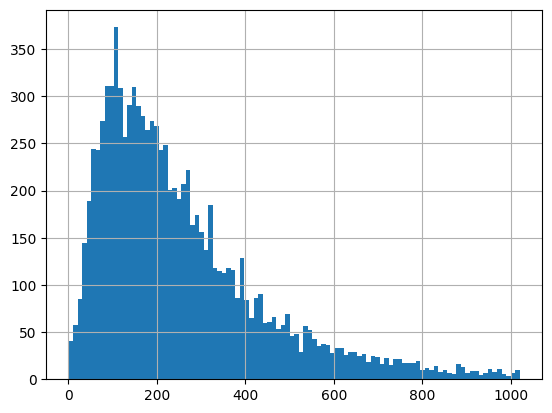

In [12]:
df.token_count.hist(bins=100);

In [13]:
from langchain import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)


system_template = "You're a legal journalist. You're helping me write a concise topic title for legal questions."
human_template = "Using the following legal questions, write a concise tag line.\n\nQUESTIONS:{body}\n\nTAG LINE:"

prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template(human_template),
    ],
    input_variables=["body"],
)
    
chain = LLMChain(
    llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo"), prompt=prompt, verbose=False
)

In [14]:
list_to_chain = df_dedup[["body"]].to_dict('records')
len(list_to_chain)

9623

In [15]:
usage = Usage()

In [16]:
from tqdm import tqdm
batch_size = 1
results = []

start_time = time.time()

for i, batch_start in tqdm(enumerate(range(0, len(list_to_chain), batch_size)), total=len(list_to_chain)//batch_size):
    batch = list_to_chain[batch_start: batch_start + batch_size]
    processed_batch = chain.run(batch)
    results.append(processed_batch)

final_time = time.time() - start_time
print(f"Total elapsed time: {final_time:.2f} seconds")

100%|██████████| 9623/9623 [3:22:50<00:00,  1.26s/it]    

Total elapsed time: 12170.79 seconds


In [17]:
usage.total_tokens()/1000*0.002

6.483348

In [18]:
# Check if 'results' length is same as the original data
assert len(results) == len(df_dedup), "Length of the result does not match with the original data"

In [19]:
results[0]

'"Legal implications of mass termination and potential for wrongful termination class-action lawsuit at Cafe Mooby"'

In [1]:
# df_dedup['llm_title'] = pd.DataFrame(results)

In [21]:
df_dedup.head(2)

,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title
0,1588353888,https://www.reddit.com/r/legaladvice/comments/...,gbmcb0,The title says most of it. I just heard back f...,My former employer fired everyone when they ha...,employment,5,"[-0.009678525544039132, -0.030654356001073007,...",156,"""Legal implications of mass termination and po..."
1,1575490057,https://www.reddit.com/r/legaladvice/comments/...,e64ze3,"In Maine, my landlord (commercial property man...",Landlord is updating snow removal policies and...,housing,7,"[-0.014251169117179163, -0.0037985407615359528...",218,"""Unforeseen snow removal policy changes and po..."


In [ ]:
# df_dedup.to_parquet("legal_reddit_df_with_titles.parquet")

In [5]:
df = pd.read_parquet("legal_reddit_df_with_titles.parquet")

In [6]:
print(df.shape)
df.head(2)

(9623, 10)


,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title
0,1588353888,https://www.reddit.com/r/legaladvice/comments/...,gbmcb0,The title says most of it. I just heard back f...,My former employer fired everyone when they ha...,employment,5,"[-0.009678525544039132, -0.030654356001073007,...",156,"""Legal implications of mass termination and po..."
1,1575490057,https://www.reddit.com/r/legaladvice/comments/...,e64ze3,"In Maine, my landlord (commercial property man...",Landlord is updating snow removal policies and...,housing,7,"[-0.014251169117179163, -0.0037985407615359528...",218,"""Unforeseen snow removal policy changes and po..."
